In [2]:
%matplotlib inline 

import os
import shutil

import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.speedups

import matplotlib.pyplot as plt

from rasterio.plot import show

# enable shapely.speedups to make the spatial queries run faster
shapely.speedups.enable()

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from rasterio.plot import plotting_extent



In [3]:
def sum_rasters(raster_list) -> np.ndarray:
    """Sum all rasters in the input list and return a reclassified array having
    values of 0 == suitable and 1 == unsuitable.
    
    :param raster_list:                 List of full path with file name and extensions to the input raster files
    :type raster_list:                  list 
    
    :return:                            A 2D array of 0, 1 suitablity designation
    
    """
    
    for idx, raster in enumerate(raster_list):

        if idx == 0:
            final_array = raster_to_array(raster).astype(np.float32)

        else:

            this_array = raster_to_array(raster)
            final_array += this_array
                
    # reclassify array back to 0 == suitable, 1 == unsuitable
    return np.where(final_array == 0, 0, 1)
    

def raster_to_array(raster_file) -> np.ndarray:
    """Read in a raster file and return a 2D NumPy array.
    
    :param raster_file:                 Full path with file name and extension to the input raster file 
    :type raster_file:                  str 
    
    :return:                            A 2D array
    
    """
    
    with rasterio.open(raster_file) as src:
        return src.read(1)

    
def plot_raster(arr, title):

    fig, ax = plt.subplots(figsize=(10, 5))

    # Define the colors you want
    cmap = ListedColormap(["grey", "navy"])

    # Define a normalization from values -> colors
    norm = colors.BoundaryNorm([0, 1], 2)

    raster_plot = ax.imshow(arr, cmap=cmap)

    # Add a legend for labels
    legend_labels = {"grey": "0", "navy": "1"}

    patches = [Patch(color=color, label=label)
               for color, label in legend_labels.items()]

    ax.legend(handles=patches,
              bbox_to_anchor=(1.15, 1),
              facecolor="white")

    ax.set_title(title)

    ax.set_axis_off()
    
    return ax
    

### Load data

In [4]:
root_dir = '/Users/d3y010/projects/cerf/data'

raster_dir = os.path.join(root_dir, 'suitability', 'v2.0.0', 'common')

power_plant_file = os.path.join(root_dir, 'eia', 'accessed_2021-06-09', 'PowerPlants_US_EIA', 'PowerPlants_US_202004.shp')

cerf_conus_file = os.path.join(root_dir, 'gis', 'shp', 'cerf_conus_boundary.shp')

cerf_states_file = os.path.join(root_dir, 'gis', 'shp', 'Promod_20121028_fips.shp')

cerf_raster_states_file = os.path.join(root_dir, 'gis', 'rast', 'promod_20121028_conus.img')

# output combined common suitability layer withoug land mask
cerf_common_suitability_file = os.path.join(root_dir, 'suitability', 'v2.0.0', 'cerf_common_suitability.tif')

state_name_file = os.path.join(root_dir, 'example', 'inputs', 'xml', 'states.xml')


# with land mask
cerf_common_suitability_masked_file = os.path.join(root_dir, 'suitability', 'v2.0.0', 'cerf_common_suitability_landmask.tif')



### Create a lookup dictionary of state id to state name

In [11]:
target_one = '<state id="'
target_two = '" shapeid="'
target_three = '">'
target_four = '</state>'

stateid_to_name = {}

with open(state_name_file) as get:
    
    for line in get:
        
        if target_one in line:
            i = int(line.split(target_one)[1].split(target_two)[0]) - 1 # adjust id to match index
            x = line.split(target_three)[1].split(target_four)[0]

            stateid_to_name[i] = x


### Create raster mask for CONUS grid cells

In [12]:
with rasterio.open(cerf_raster_states_file) as src:
    
    land_mask_arr = src.read(1)
    mask_metadata = src.meta
    
    land_mask_arr = np.where(land_mask_arr == src.nodata, np.nan, 0)


### Generate a list of all CERF common suitablity rasters and extract the CRS info

In [13]:
raster_list = [os.path.join(raster_dir, i) for i in os.listdir(raster_dir) if i[-4:] == '.tif']

# extract the coordinate reference system from CERF's raster
with rasterio.open(raster_list[0]) as src:
    target_crs = src.crs


In [50]:
download_dir = '/Users/d3y010/projects/cerf/data_validation'

r_list = [os.path.join(download_dir, i) for i in os.listdir(download_dir) if i[-4:] == '.tif']

r_list


['/Users/d3y010/projects/cerf/data_validation/pnnl_fws_national_wildlife_refuges_2019_conus.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_WILDNET_Wilderness_Areas_2012_CONUS.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_Wilderness_Lands_2021_CONUS.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_FWS_Lands_2021_CONUS.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_USFS_Wilderness_Ares_2015_CONUS.tif',
 '/Users/d3y010/projects/cerf/data_validation/pnnl_blm_nlcs_national_monument_2015_conus.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_WDPA_TNC_Managed_Lands_2016_CONUS.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_USFS_Administrative_Boundaries_2021_CONUS.tif',
 '/Users/d3y010/projects/cerf/data_validation/pnnl_nlcd_wetlands_1km_2019_conus.tif',
 '/Users/d3y010/projects/cerf/data_validation/PNNL_BLM_Scenic_Rivers_1km_2009.tif',
 '/Users/d3y010/projects/cerf/data_validation/pnnl_slope_12pct_or_less_1km.tif',
 '/Users/d3y010/proje

In [55]:
t_raster = '/Users/d3y010/projects/cerf/data/suitability/v2.0.0/common/pnnl_usfs_lands_2021_conus.tif'

with rasterio.open(t_raster) as src:
    
    metadata = src.meta
    
    print(metadata)
    
    for i in r_list:
        
        with rasterio.open(i) as getit:
            
            base = os.path.basename(i).lower()
            dest_name = os.path.join(raster_dir, base)
            
            tp = getit.meta['dtype']
            
            if tp != 'uint8':

                arr = getit.read(1).astype(np.uint8)

                with rasterio.open(dest_name, 'w', **metadata) as out:

                    out.write(arr, 1)
            else:
                
                arr = getit.read(1)
                shutil.copy(i, dest_name)
                
            



{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 3.0, 'width': 4693, 'height': 2999, 'count': 1, 'crs': CRS.from_wkt('PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1000.0, 0.0, -2405552.8355,
       0.0, -1000.0, 1609934.7995)}


### Determine aggregate suitablity over the CONUS

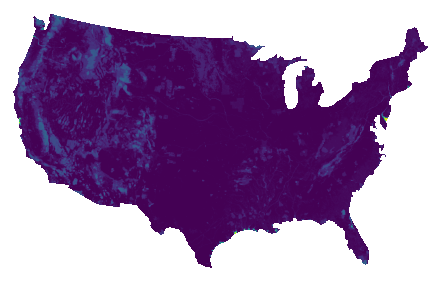

<AxesSubplot:>

In [24]:
for idx, raster in enumerate(raster_list):

    with rasterio.open(raster) as src:
        metadata = src.meta
        
        if idx == 0:
            arr = src.read(1).astype(np.uint8)
            
        else:
            arr += src.read(1).astype(np.uint8)

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_axis_off()

show(arr + land_mask_arr, ax)


### Create total common suitablity layer

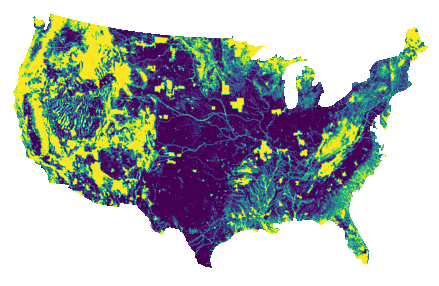

<AxesSubplot:>

In [25]:
# create common combined exclusion array
common_arr = np.where(arr == 0, 0, 1).astype(np.uint8)

with rasterio.open(cerf_common_suitability_file, 'w', **metadata) as out:
    out.write(common_arr, 1)

    
mask_metadata.update({'dtype': 'float64'})

with rasterio.open(cerf_common_suitability_masked_file, 'w', **mask_metadata) as out:
    out.write(common_arr + land_mask_arr, 1)


fig, ax = plt.subplots(figsize=(10, 5))

ax.set_axis_off()

show(common_arr + land_mask_arr, ax)


### Read in EIA power plant and CERF boundary shapefiles to GeoDataFrames

Reproject the data to CERF's projected coordinate system

In [26]:
power_plant_gdf = gpd.read_file(power_plant_file).to_crs(target_crs)

boundary_gdf = gpd.read_file(cerf_conus_file).to_crs(target_crs)

states_gdf = gpd.read_file(cerf_states_file).to_crs(target_crs)


### Filter out only target primary sources that correspond with CERF technologies

In [27]:
# filter out only target primary sources that correspond with CERF technologies; wind and solar evaluated separately 
primary_source_list = ['natural gas', 'nuclear', 'coal', 'petroleum', 'biomass']

power_plant_gdf = power_plant_gdf.loc[power_plant_gdf['PrimSource'].isin(primary_source_list)]


### Visualize all EIA power plants with applicable technologies over CERF's CONUS extent

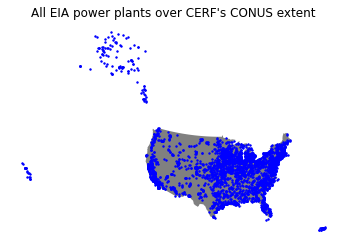

In [28]:
fig, ax = plt.subplots()
plt.title("All EIA power plants over CERF's CONUS extent")

boundary_gdf.plot(ax=ax, facecolor='gray')
power_plant_gdf.plot(ax=ax, color='blue', markersize=2)

ax.set_axis_off()


### Only keep power plants that are within CERF's CONUS extent

In [29]:
# get power plants that are within CERF's CONUS boundary
power_plant_mask = power_plant_gdf.within(boundary_gdf.loc[0, 'geometry'])

power_plant_conus = power_plant_gdf.loc[power_plant_mask].copy()


### Optional. Filter out all plants < 80 MW

In [35]:
power_plant_conus = power_plant_conus.loc[power_plant_conus['Total_MW'] >= 80].copy()


### Visualize EIA power plants with applicable technologies that are within CERF's CONUS extent

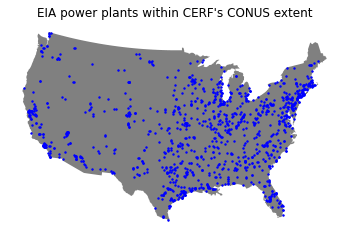

In [36]:
fig, ax = plt.subplots()
plt.title("EIA power plants within CERF's CONUS extent")

boundary_gdf.plot(ax=ax, facecolor='gray')
power_plant_conus.plot(ax=ax, color='blue', markersize=2)

ax.set_axis_off()


### Determine which power plants fall on suitable and unsuitable land

In [37]:
power_plant_conus['xcoord'] = power_plant_conus.geometry.x
power_plant_conus['ycoord'] = power_plant_conus.geometry.y

coords = [(x,y) for x, y in zip(power_plant_conus['xcoord'], power_plant_conus['ycoord'])]


### Validation for individual common suitablity layers for the CONUS

In [38]:
# dictionary to store outputs in
d = {'layer': [], 'invalid': [], 'valid': []}

# total number of power plants for the CONUS
n_power_plants_conus = len(coords)

# update suitability for each power plant once it is within a grid cell that is unsuitable
for raster in raster_list:

    with rasterio.open(raster) as src:

        # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
        extract_suitability_at_points = [int(i[0]) for i in src.sample(coords)]
        
        # get the count of unsuitable designations
        n_unsuitable_plants = len([i for i in extract_suitability_at_points if i == 1])
        
        # append the results to the output dictionary
        d['layer'].append(os.path.basename(raster.lower()))
        d['invalid'].append(n_unsuitable_plants)
        d['valid'].append(n_power_plants_conus - n_unsuitable_plants)

# convert the output to a pandas data frame
layer_specific_diagnostics = pd.DataFrame(d)

layer_specific_diagnostics['fraction'] = layer_specific_diagnostics['invalid'] / n_power_plants_conus

layer_specific_diagnostics


,layer,invalid,valid,fraction
0,pnnl_fws_national_wildlife_refuges_2019_conus.tif,34,1181,0.027984
1,pnnl_wildnet_wilderness_areas_2012_conus.tif,25,1190,0.020576
2,pnnl_wilderness_lands_2021_conus.tif,25,1190,0.020576
3,pnnl_fws_lands_2021_conus.tif,34,1181,0.027984
4,pnnl_usfs_wilderness_ares_2015_conus.tif,25,1190,0.020576
5,pnnl_blm_nlcs_national_monument_2015_conus.tif,25,1190,0.020576
6,pnnl_wdpa_tnc_managed_lands_2016_conus.tif,29,1186,0.023868
7,pnnl_usfs_administrative_boundaries_2021_conus...,32,1183,0.026337
8,pnnl_nlcd_wetlands_1km_2019_conus.tif,205,1010,0.168724
9,pnnl_blm_scenic_rivers_1km_2009.tif,25,1190,0.020576


### Validation for all common suitability layers combined

In [39]:
# stage suitability designation for each power plant
power_plant_conus['suitability'] = 0

# update suitability for each power plant once it is within a grid cell that is unsuitable
for raster in raster_list:

    with rasterio.open(raster) as src:

        # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
        extract_suitability_at_points = [int(i[0]) for i in src.sample(coords)]

    # if unsuitable, update value
    power_plant_conus['suitability'] = np.where(power_plant_conus['suitability'] < extract_suitability_at_points,
                                                extract_suitability_at_points,
                                                power_plant_conus['suitability'])

suitable_power_plants = power_plant_conus.loc[power_plant_conus['suitability'] == 0].copy()
unsuitable_power_plants = power_plant_conus.loc[power_plant_conus['suitability'] == 1].copy()

# add to diagnostic data frame
total_common = ['combined_common_suitability_layers', 
                unsuitable_power_plants.shape[0], 
                suitable_power_plants.shape[0], 
                unsuitable_power_plants.shape[0] / n_power_plants_conus]

layer_specific_diagnostics.loc[len(layer_specific_diagnostics.index)] = total_common


##### Plot map

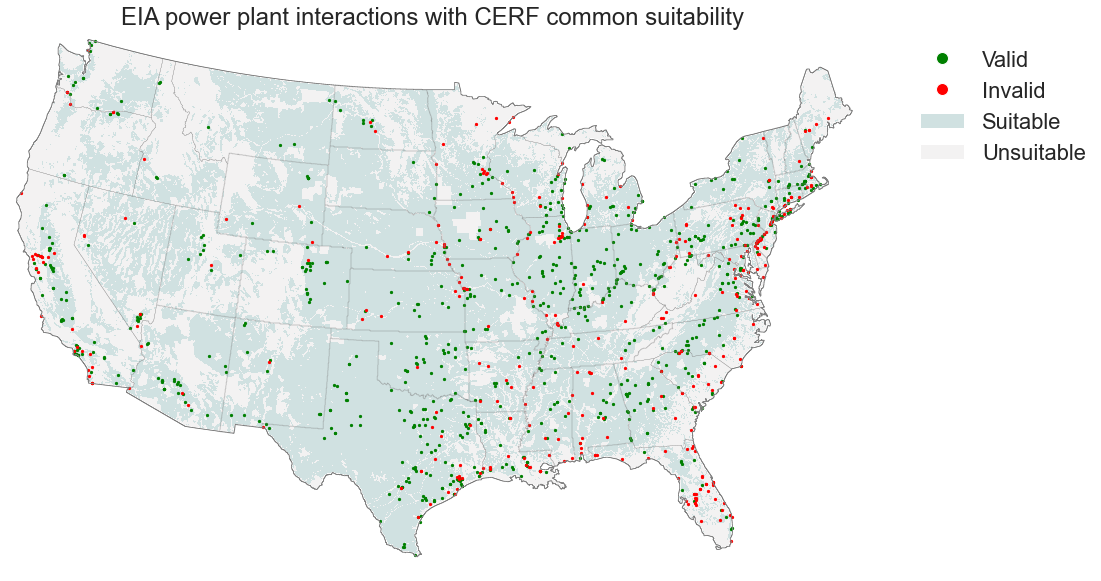

In [40]:
# generate plot
sns.set(font_scale=2) 

fig, ax = plt.subplots(figsize=(20, 10))

plt.title("EIA power plant interactions with CERF common suitability")

suitable_color = "#d0e1e1"
unsuitable_color = "#f3f2f2"

cmap = ListedColormap([suitable_color, unsuitable_color])

with rasterio.open(cerf_common_suitability_masked_file) as src:
    
    # boundary_gdf.plot(ax=ax, facecolor='lightgray')
    show(src, ax=ax, cmap=cmap) #, interpolation='none', ax=ax)
    states_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.2)
    boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)
    suitable_power_plants.plot(ax=ax, color='green', markersize=5)
    unsuitable_power_plants.plot(ax=ax, color='red', markersize=5)

    # construct legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=12, label='Valid'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Invalid'),
                       Patch(facecolor=suitable_color, label='Suitable'),
                       Patch(facecolor=unsuitable_color, label='Unsuitable')]

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(1.05, 1),
              facecolor="white",
              frameon=False)

    ax.set_axis_off()

    sns.set(font_scale=1) 


##### Plot bar

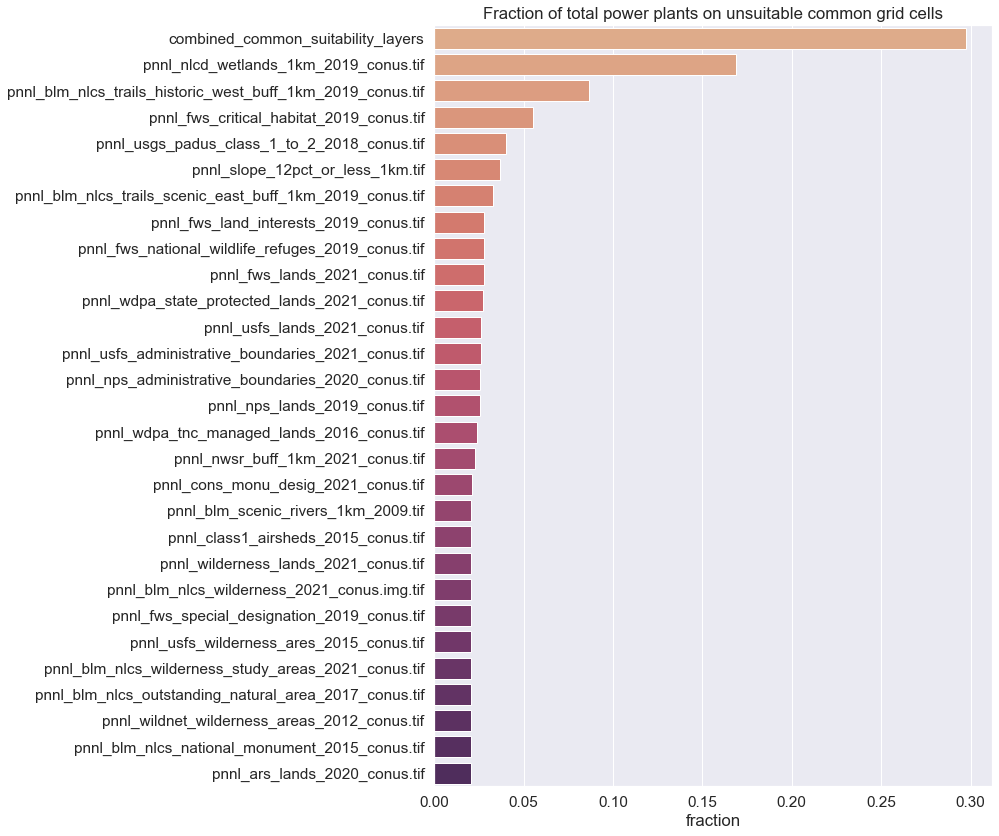

In [41]:
display_df = layer_specific_diagnostics.sort_values(by='fraction', ascending=False).copy()

sns.set(font_scale=1.4) 

fig, ax = plt.subplots(figsize=(10, 14))

ax = sns.barplot(x="fraction", y="layer", data=display_df, palette="flare")

ax.set(ylabel=None, 
       title='Fraction of total power plants on unsuitable common grid cells')

sns.set(font_scale=1) 


### Determine the number of invalid power plants for each state

In [42]:
state_list = states_gdf['ObjectID'].unique()

state_d = {'state_name': [], 'invalid': [], 'valid': [], 'fraction': []}

with rasterio.open(cerf_common_suitability_file) as src:

    for i in state_list:

        target_state_gdf = states_gdf.loc[states_gdf['ObjectID'] == i].copy()

        state_power_plant_mask = power_plant_gdf.within(target_state_gdf.geometry.values[0])

        state_power_plant = power_plant_gdf.loc[state_power_plant_mask].copy()

        state_power_plant['xcoord'] = state_power_plant.geometry.x
        state_power_plant['ycoord'] = state_power_plant.geometry.y

        state_coords = [(x,y) for x, y in zip(state_power_plant['xcoord'], state_power_plant['ycoord'])]
        
        n_power_plants_state = len(state_coords)
        
        # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
        state_extract_suitability_at_points = [int(i[0]) for i in src.sample(state_coords)]
        
        # get the count of unsuitable designations
        n_unsuitable_plants_state = len([i for i in state_extract_suitability_at_points if i == 1])
        
        n_suitable_plants_state = n_power_plants_state - n_unsuitable_plants_state
        
        state_d['state_name'].append(i)
        state_d['invalid'].append(n_unsuitable_plants_state)
        state_d['valid'].append(n_suitable_plants_state)
        state_d['fraction'].append(n_unsuitable_plants_state / n_power_plants_state)

states_diag_df = pd.DataFrame(state_d)


##### Plot map

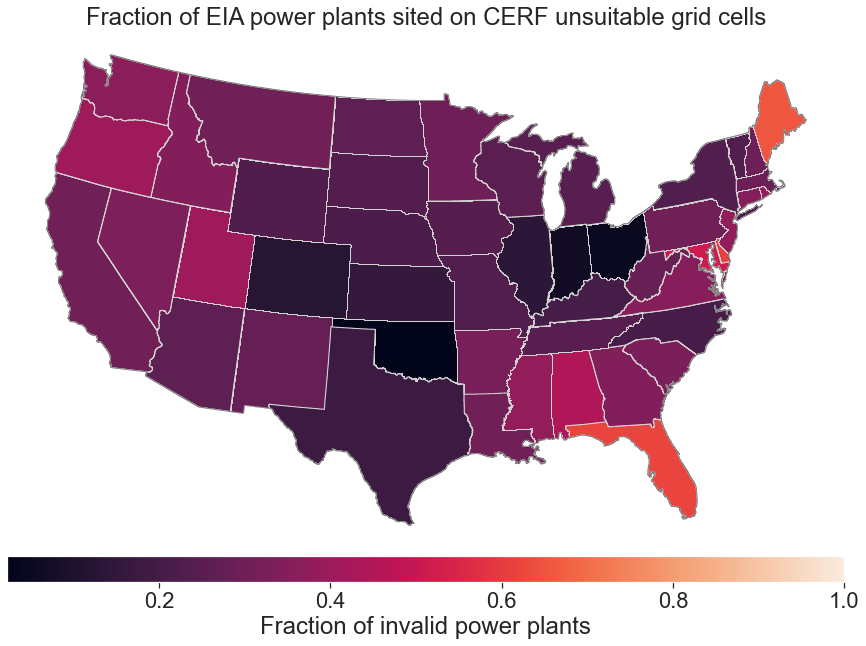

In [43]:
# get a dictionary of state ids to invalid fraction
states_eval = states_diag_df.copy()
states_eval.set_index('state_name', inplace=True)
state_lookup = states_eval['fraction'].to_dict()

# apply fraction to the states geodataframe
states_gdf['fraction'] = states_gdf['ObjectID'].map(state_lookup)

# plot map
sns.set(font_scale=2) 

fig, ax = plt.subplots(1, 1, figsize=(15, 20))

plt.title("Fraction of EIA power plants sited on CERF unsuitable grid cells")

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

s = states_gdf.plot(column='fraction', 
                ax=ax,
                edgecolor='lightgrey',
                legend=True,
                legend_kwds={'label': "Fraction of invalid power plants", 
                             'orientation': "horizontal"},
                cax=cax)

boundary_gdf.boundary.plot(ax=ax, edgecolor='gray', lw=0.8)

ax.set_axis_off()

sns.set(font_scale=1) 


##### Plot bar

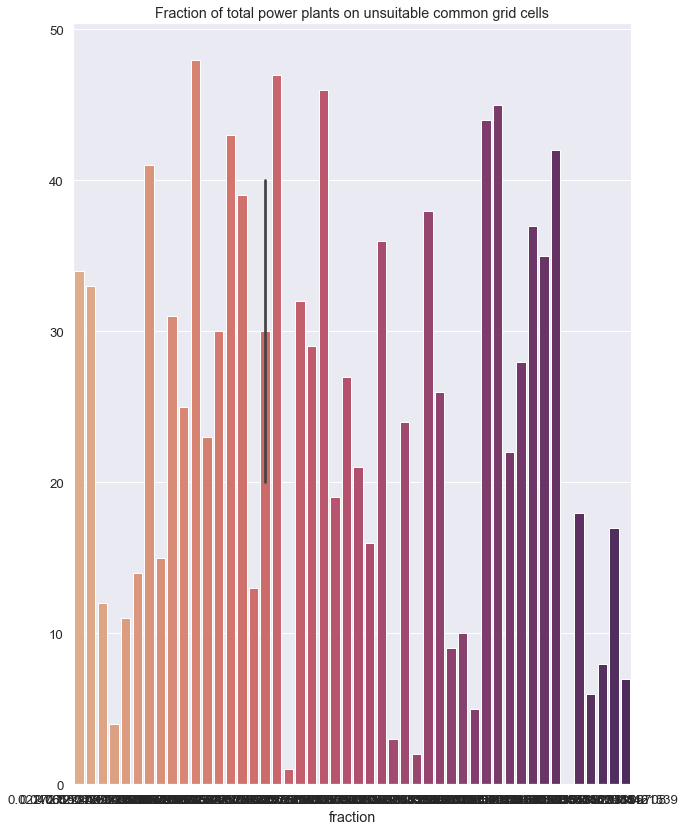

In [44]:
display_df = states_diag_df.sort_values(by='fraction', ascending=False).copy()

sns.set(font_scale=1.2) 

fig, ax = plt.subplots(figsize=(10, 14))

ax = sns.barplot(x="fraction", y="state_name", data=display_df, palette="flare")

ax.set(ylabel=None, 
       title='Fraction of total power plants on unsuitable common grid cells')

sns.set(font_scale=1) 


### Create a heatmap of states (y-axis) to layers (x-axis) for fraction of invalid power plants

In [45]:
state_list = states_gdf['ObjectID'].unique()

heat_df = pd.DataFrame({'state_name': state_list})

head_d = {}

for raster in raster_list:
    
    base_name = os.path.basename(raster).lower()

    with rasterio.open(raster) as src:

        l = []
        
        for i in state_list:

            target_state_gdf = states_gdf.loc[states_gdf['ObjectID'] == i].copy()

            state_power_plant_mask = power_plant_gdf.within(target_state_gdf.geometry.values[0])

            state_power_plant = power_plant_gdf.loc[state_power_plant_mask].copy()

            state_power_plant['xcoord'] = state_power_plant.geometry.x
            state_power_plant['ycoord'] = state_power_plant.geometry.y

            state_coords = [(x,y) for x, y in zip(state_power_plant['xcoord'], state_power_plant['ycoord'])]

            n_power_plants_state = len(state_coords)

            # extract the suitability value (0 == suitable; 1 == unsuitable) for each power plant
            state_extract_suitability_at_points = [int(i[0]) for i in src.sample(state_coords)]

            # get the count of unsuitable designations
            n_unsuitable_plants_state = len([i for i in state_extract_suitability_at_points if i == 1])

            n_suitable_plants_state = n_power_plants_state - n_unsuitable_plants_state
            
            # fraction of invalid plants for the target state per layer
            l.append(n_unsuitable_plants_state / n_power_plants_state)

        heat_df[base_name] = l



##### Plot heatmap

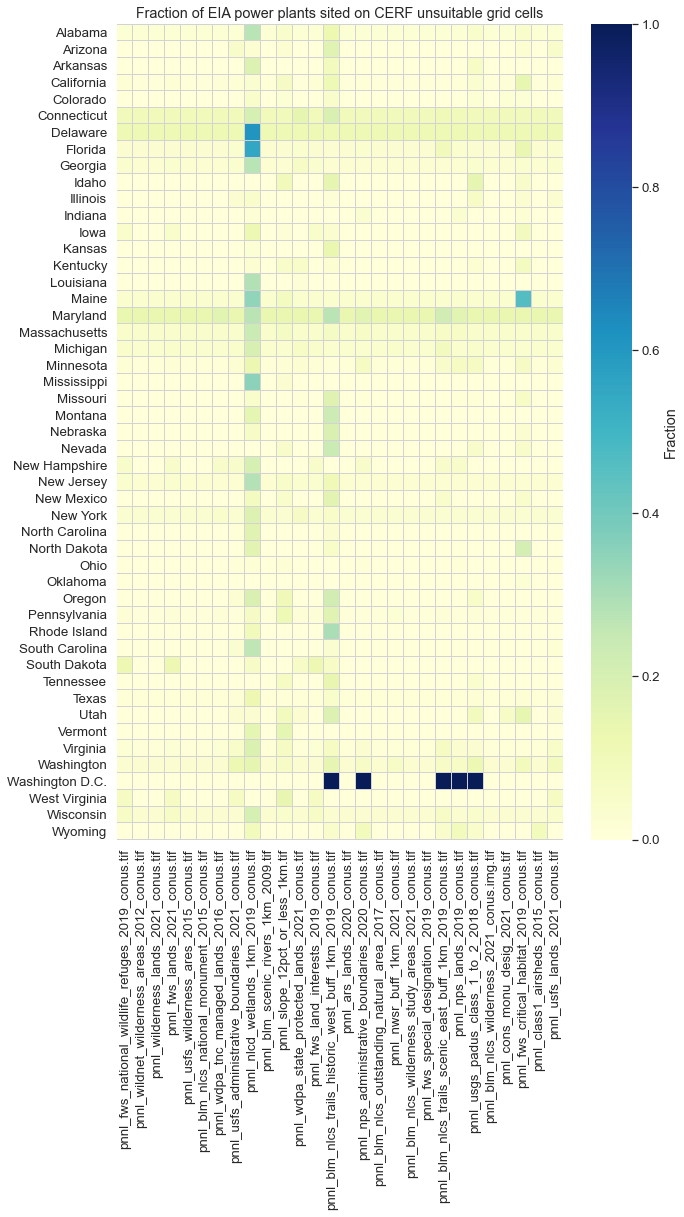

In [46]:
dfx = heat_df.copy()

dfx['state_name'] = dfx['state_name'].map(stateid_to_name)
dfx = dfx.sort_values('state_name')

dfx.set_index('state_name', inplace=True)

dfx.columns = [i.lower() for i in dfx.columns]

# plot map
sns.set(font_scale=1.2) 

fig, ax = plt.subplots(1, 1, figsize=(10, 15))

plt.title("Fraction of EIA power plants sited on CERF unsuitable grid cells")

ax = sns.heatmap(dfx, 
                 linewidths=.005, 
                 linecolor='lightgrey', 
                 cmap="YlGnBu",
                 cbar_kws={'label': 'Fraction'})

ax.set(xlabel=None, ylabel=None)

sns.set(font_scale=1) 


### Calculate the distance to the nearest suitable grid cell for invalid data

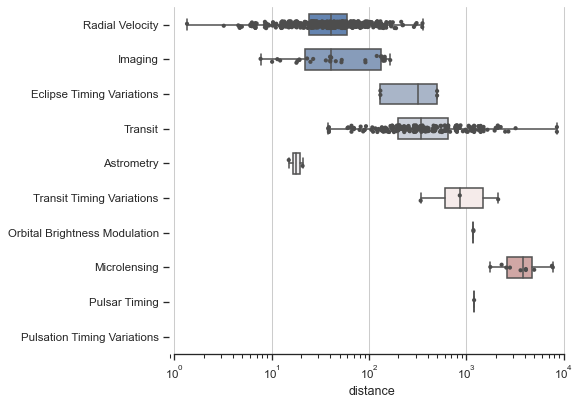

### Determine the unique unsuitable contributions of each layer

In [53]:
# set up additional diagnostics to be input in the data frame 
layer_specific_diagnostics['suitable_grid_cells'] = 0
layer_specific_diagnostics['unsuitable_grid_cells'] = 0
layer_specific_diagnostics['unique_unsuitable_grid_cells'] = 0

# column names to update
update_columns = ['suitable_grid_cells', 'unsuitable_grid_cells', 'unique_unsuitable_grid_cells']

for target_raster in raster_list:
    
    base_name = os.path.basename(target_raster.lower())
    
    print(f"Processing layer:  {base_name}")
    
    # get a list of raster files that do not contain the target raster
    remaining_raster_list = [i for i in raster_list if target_raster != i]
    
    # generate a suitability array (0 == suitable, 1 == unsuitable) for all rasters that are not the target
    remaining_suitability_array = sum_rasters(remaining_raster_list)
    
    # read target raster file to an array 
    target_suitability_array = raster_to_array(target_raster).astype(np.float32)
        
    # get the number of suitable and unsuitable grid cells in the target raster
    n_target_suitable = np.where(target_suitability_array == 0)[0].shape[0]
    n_target_unsuitable = np.where(target_suitability_array == 1)[0].shape[0]
    
    # sum remaining and target arrays so that 0 == suitable, 1 == unsuitable only in target, and 2 == unsuitable in remaining and target
    target_suitability_array += remaining_suitability_array
    
    # find the number of unsuitable grid cells that are only in the target raster
    n_unique_unsuitable = np.where(target_suitability_array == 1)[0].shape[0]
    
    # get the index of the target layer in the diagnostics data frame 
    row_index = layer_specific_diagnostics.loc[layer_specific_diagnostics['layer'] == base_name].index[0]
    
    # add results to diagnostics data frame
    layer_specific_diagnostics.loc[row_index, update_columns] = [n_target_suitable, n_target_unsuitable, n_unique_unsuitable]   



Processing layer:  pnnl_wildnet_wilderness_areas_2012_conus.tif
Processing layer:  pnnl_wilderness_lands_2021_conus.tif
Processing layer:  pnnl_fws_lands_2021_conus.tif
Processing layer:  pnnl_fws_national_wildlife_refuges_2021_conus.tif
Processing layer:  pnnl_usfs_wilderness_ares_2015_conus.tif
Processing layer:  pnnl_blm_nlcs_national_monument_2015_conus.tif
Processing layer:  pnnl_wdpa_tnc_managed_lands_2016_conus.tif
Processing layer:  pnnl_usfs_administrative_boundaries_2021_conus.tif
Processing layer:  pnnl_nlcd_wetlands_1km_2019_conus.tif
Processing layer:  pnnl_slope_12pct_or_less_1km.tif
Processing layer:  pnnl_wdpa_state_protected_lands_2021_conus.tif
Processing layer:  pnnl_blm_nlcs_trails_historic_west_buff_1km_2019_conus.tif
Processing layer:  pnnl_ars_lands_2020_conus.tif
Processing layer:  pnnl_blm_nlcs_outstanding_natural_area_2017_conus.tif
Processing layer:  pnnl_nwsr_buff_1km_2021_conus.tif
Processing layer:  pnnl_blm_nlcs_wilderness_study_areas_2021_conus.tif
Proce

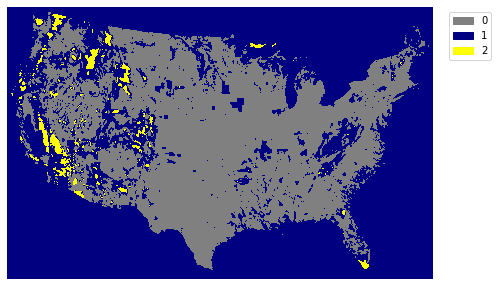

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

# Define the colors you want
cmap = ListedColormap(["grey", "navy", "yellow"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 1, 2], 3)

raster_plot = ax.imshow(target_suitability_array, cmap=cmap)


# Add a legend for labels
legend_labels = {"grey": "0", "navy": "1" , "yellow": "2"}

patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]

ax.legend(handles=patches,
          bbox_to_anchor=(1.15, 1),
          facecolor="white")

ax.set_axis_off()


#### First and second order contribution to invalid siting

### Build combined common suitability raster

In [79]:
temp_raster = '/Users/d3y010/Desktop/common_test.tif'

for idx, raster in enumerate(raster_list):

    if idx == 0:
        
        with rasterio.open(raster) as src:
            
            arr = src.read(1)
            profile = src.profile
            
    else:
        
        with rasterio.open(raster) as src:
            
            arx = src.read(1)
            arr += arx
            
arr = np.where(arr == 0, 0, 1)
            
with rasterio.open(temp_raster, 'w', **profile) as out:
    
    out.write(arr.astype(rasterio.float32), 1)
            
        
            
        
